## 1. Reading Modules


In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input


In [2]:
filelist  = []

for dirname, _, filenames in os.walk('cat-breeds-dataset'):
    for filename in filenames:
        filelist.append (os.path.join(dirname, filename))


In [3]:
len(filelist)

126608

### Taking only those 10 labels given in the assignment.

In [5]:
labels_needed = ['Bombay', 'Calico', 'Burmese', 'Himalayan',
'Munchkin', 'Ragdoll', 'Siberian', 'British Shorthair', 'Russian Blue', 
                 'Dilute Calico']

In [6]:
Filepaths   = []
labels = []

for image_file in filelist:
    label = image_file.split(os.path.sep)[-2]
    if label in labels_needed:

        Filepaths.append(image_file)
        labels.append(label)
    


In [7]:
set(labels)

{'Bombay',
 'British Shorthair',
 'Burmese',
 'Calico',
 'Dilute Calico',
 'Himalayan',
 'Munchkin',
 'Ragdoll',
 'Russian Blue',
 'Siberian'}

In [8]:
len(Filepaths), len(labels)

(15654, 15654)

### Creating a dataframe with file paths and the labels for them

In [9]:
df = pd.DataFrame( list( zip (Filepaths, labels) ), columns = ['Filepath', 'Labels'] )

,Filepath,Labels
0,/kaggle/input/cat-breeds-dataset/images/Siberi...,Siberian
1,/kaggle/input/cat-breeds-dataset/images/Siberi...,Siberian
2,/kaggle/input/cat-breeds-dataset/images/Siberi...,Siberian
3,/kaggle/input/cat-breeds-dataset/images/Siberi...,Siberian
4,/kaggle/input/cat-breeds-dataset/images/Siberi...,Siberian
...,...,...
15649,/kaggle/input/cat-breeds-dataset/images/Bombay...,Bombay
15650,/kaggle/input/cat-breeds-dataset/images/Bombay...,Bombay
15651,/kaggle/input/cat-breeds-dataset/images/Bombay...,Bombay
15652,/kaggle/input/cat-breeds-dataset/images/Bombay...,Bombay


In [10]:
from sklearn.utils import shuffle
df = (df.sample(frac = 1).reset_index()).drop(columns = 'index')

,Filepath,Labels
0,/kaggle/input/cat-breeds-dataset/images/Russia...,Russian Blue
1,/kaggle/input/cat-breeds-dataset/images/Calico...,Calico
2,/kaggle/input/cat-breeds-dataset/images/Britis...,British Shorthair
3,/kaggle/input/cat-breeds-dataset/images/Himala...,Himalayan
4,/kaggle/input/cat-breeds-dataset/images/Calico...,Calico
...,...,...
15649,/kaggle/input/cat-breeds-dataset/images/Himala...,Himalayan
15650,/kaggle/input/cat-breeds-dataset/images/Britis...,British Shorthair
15651,/kaggle/input/cat-breeds-dataset/images/Calico...,Calico
15652,/kaggle/input/cat-breeds-dataset/images/Calico...,Calico


### Displaying first 12 pictures

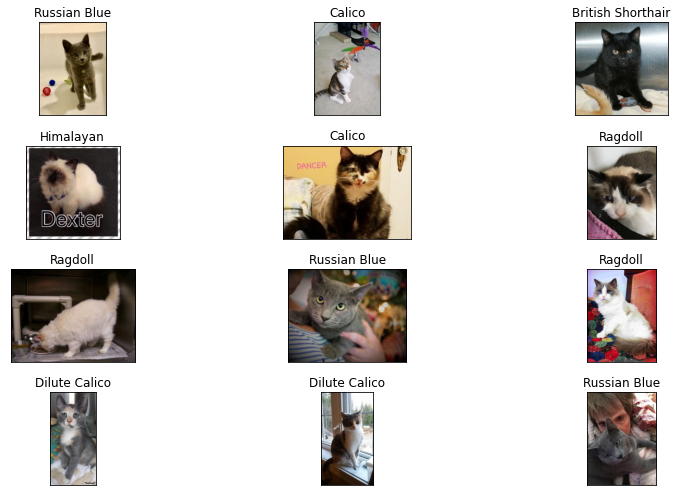

In [11]:
f,a = plt.subplots(nrows=4, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Labels[i])
    
plt.tight_layout()
plt.show()

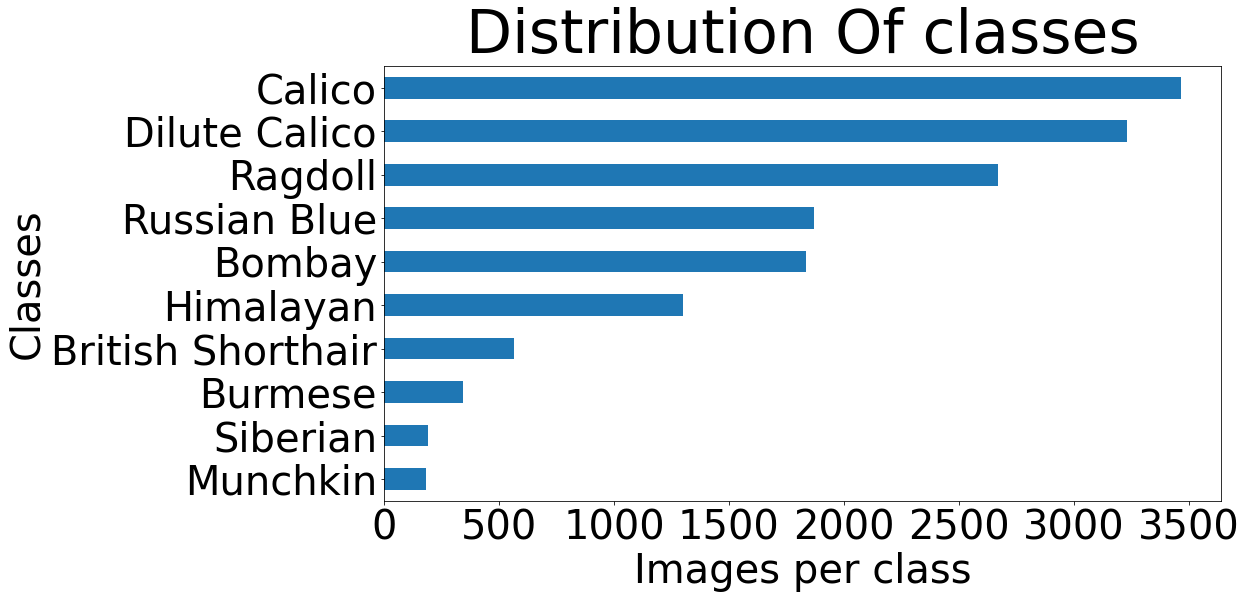

In [12]:
ax=pd.value_counts(df['Labels'],ascending=True).plot(kind='barh',
                                                       fontsize="40",
                                                       title="Distribution Of classes",
                                                       figsize=(15,8))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.title.set_size(60)
plt.show()

### Checking for class imbalance

In [13]:
df.Labels.value_counts()

Calico               3468
Dilute Calico        3230
Ragdoll              2669
Russian Blue         1870
Bombay               1835
Himalayan            1301
British Shorthair     567
Burmese               344
Siberian              189
Munchkin              181
Name: Labels, dtype: int64

* Class imbalance present.

### Splitting the data And Creating data generator

In [14]:
train_ratio = .75
validation_ratio = 0.10
test_ratio = 0.25

train, test = train_test_split(df, test_size = test_ratio )
val, test = train_test_split(test, test_size=test_ratio/(test_ratio + validation_ratio))

In [18]:
img_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')
   

x_train =  img_datagen.flow_from_dataframe(dataframe = train,  x_col='Filepath', y_col='Labels',  target_size=(299, 299), shuffle=False, batch_size=10, seed=10)
x_val = img_datagen.flow_from_dataframe(dataframe = val,  x_col='Filepath', y_col='Labels',  target_size=(299, 299), shuffle=False, batch_size=10, seed=10)
x_test = img_datagen.flow_from_dataframe(dataframe = test,  x_col='Filepath', y_col='Labels',  target_size=(299, 299), shuffle=False, batch_size=10, seed=10)

Found 11740 validated image filenames belonging to 10 classes.
Found 1118 validated image filenames belonging to 10 classes.
Found 2796 validated image filenames belonging to 10 classes.


In [19]:
x_train

### Modelling

In [20]:

i_model = InceptionV3(weights= 'imagenet', include_top=False, input_shape=(299, 299, 3))

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in i_model.layers:
    layer.trainable = False
    
i_model.summary() 

In [21]:
from keras.models import Sequential
from keras.layers.pooling import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout


model = Sequential()
model.add(i_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(10, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 22,066,346
Trainable params: 22,031,914
Non-trainable params: 34,432
_________________________________________________________________


In [22]:
model.compile(optimizer = SGD(),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [23]:
history = model.fit(x_train, validation_data = x_val,steps_per_epoch = 175,validation_steps = 44,
                epochs = 5, verbose = 2)

Epoch 1/5
175/175 - 81s - loss: 1.3681 - accuracy: 0.5109 - val_loss: 1.0753 - val_accuracy: 0.6273
Epoch 2/5
175/175 - 60s - loss: 1.1543 - accuracy: 0.6029 - val_loss: 1.1078 - val_accuracy: 0.6023
Epoch 3/5
175/175 - 58s - loss: 1.0415 - accuracy: 0.6577 - val_loss: 1.0980 - val_accuracy: 0.6182
Epoch 4/5
175/175 - 57s - loss: 0.9309 - accuracy: 0.6794 - val_loss: 1.1922 - val_accuracy: 0.6205
Epoch 5/5
175/175 - 55s - loss: 0.9582 - accuracy: 0.6789 - val_loss: 0.9005 - val_accuracy: 0.7318


### Predicting on test data

In [24]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
predictions

array([7, 3, 7, ..., 3, 0, 7])

In [25]:
labels = x_train.class_indices
labels

{'Bombay': 0,
 'British Shorthair': 1,
 'Burmese': 2,
 'Calico': 3,
 'Dilute Calico': 4,
 'Himalayan': 5,
 'Munchkin': 6,
 'Ragdoll': 7,
 'Russian Blue': 8,
 'Siberian': 9}

In [26]:
test["Labels"].replace({"Bombay": 0,'British Shorthair': 1,
 'Burmese': 2,
 'Calico': 3,
 'Dilute Calico': 4,
 'Himalayan': 5,
 'Munchkin': 6,
 'Ragdoll': 7,
 'Russian Blue': 8,
 'Siberian': 9}, inplace = True)


# Evaluating the test data

## Test Accuracy

In [27]:
test_accuracy = model.evaluate(x_test)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

280/280 [==============================] - 57s 204ms/step - loss: 0.8884 - accuracy: 0.7057
Test accuracy is :  70.56509256362915 %


## Confusion Matrix

In [29]:
confusion_matrix(test.Labels , predictions)


array([[295,   0,   1,   3,   0,   0,   0,   0,   2,   0],
       [ 10,   8,   0,  13,  22,   3,   0,  20,  34,   0],
       [ 14,   1,   7,   2,   5,   9,   0,  15,   1,   1],
       [ 16,   0,   0, 449, 108,   3,   0,  23,   7,   0],
       [ 10,   1,   0, 105, 439,   4,   0,  46,  36,   0],
       [  1,   0,   0,   1,   1, 157,   0,  62,   0,   1],
       [  6,   0,   0,   4,  11,   3,   0,   9,   5,   0],
       [ 10,   2,   1,  11,  15, 106,   0, 328,   4,   6],
       [ 14,   0,   0,   0,   7,   1,   0,   4, 273,   0],
       [  1,   0,   0,   5,   5,   8,   0,  18,   1,   2]])

## F1 Score

In [30]:
from sklearn.metrics import accuracy_score, f1_score
print('F1 score is',f1_score(test.Labels, predictions, average = 'weighted') *100, "%")


F1 score is 67.61944724357448 %


## ROC - AUC Score

In [31]:
predicted_probab =model.predict_proba(x_test)
predicted_probab

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


array([[2.24471581e-03, 6.48340909e-04, 4.48354613e-03, ...,
        7.10429192e-01, 5.26006916e-04, 6.06052484e-03],
       [3.05354744e-02, 2.47017201e-03, 1.46455273e-01, ...,
        1.35622606e-01, 1.13308374e-02, 1.10609671e-02],
       [1.19472835e-02, 2.87969057e-02, 6.72524516e-03, ...,
        5.09899020e-01, 9.83562786e-03, 9.32915285e-02],
       ...,
       [4.22054529e-03, 1.82272587e-02, 1.14802225e-02, ...,
        5.80486981e-03, 4.13288586e-02, 1.63245462e-02],
       [9.69571233e-01, 1.01499003e-03, 1.23407999e-02, ...,
        4.35800711e-03, 4.42392629e-04, 3.55296070e-03],
       [5.97578380e-03, 1.80189591e-02, 1.02115022e-02, ...,
        3.26138645e-01, 1.91606060e-02, 3.29596177e-02]], dtype=float32)

In [32]:
print("ROC- AUC score is", roc_auc_score( test.Labels, predicted_probab, multi_class='ovr')*100)

ROC- AUC score is 91.5819868633563
